In [13]:
# Imports as always.
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from PIL import Image

from datetime import datetime

from data_handling import ISICDataset

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121


## Data Handling

In [4]:
# Pre-define a couple of transform functions to and from tensors and images.
tensor_to_image = transforms.ToPILImage()
image_to_tensor = transforms.ToTensor()

In [6]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

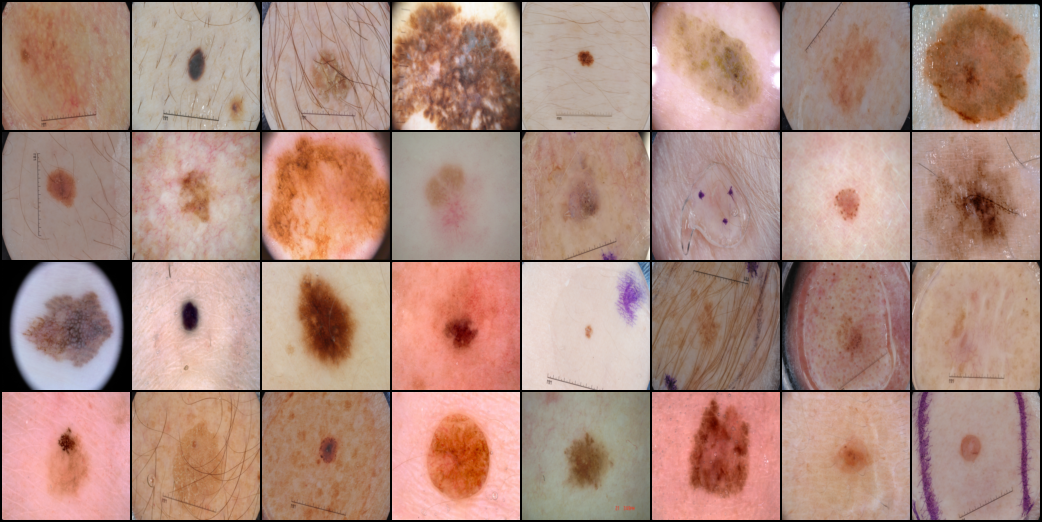

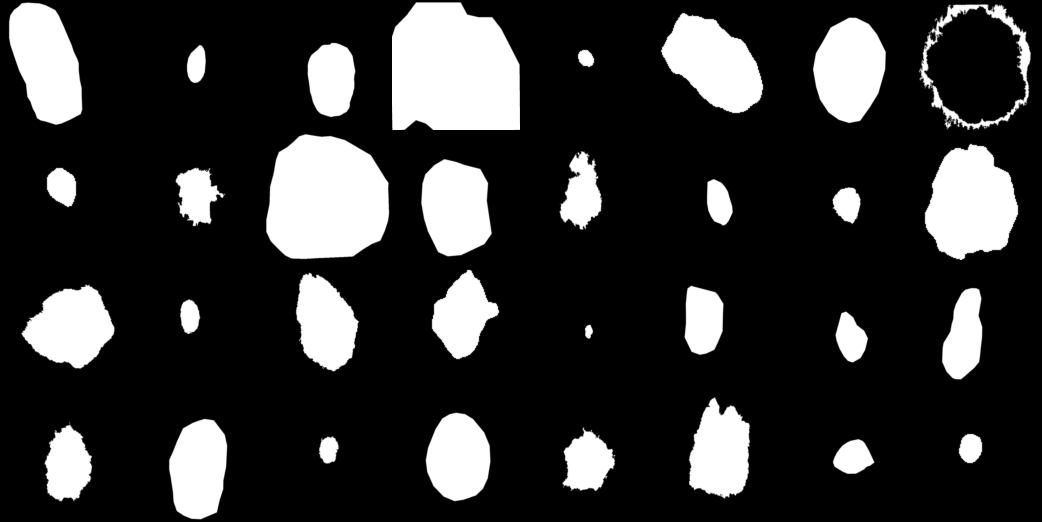

In [7]:
train_inputs, train_targets = next(iter(train_dataloader))

input_grid = torchvision.utils.make_grid(train_inputs, nrow=8)
display(tensor_to_image(input_grid))

target_grid = torchvision.utils.make_grid(train_targets, nrow=8)
display(tensor_to_image(target_grid))

## SegNet Model

In [9]:
class DownConv2(nn.Module):
    def __init__(self, n_in_channels, n_out_channels, kernel_size, activation_func):
        super().__init__()
        
        # The model's structure is (conv -> batch norm -> activate) x 2.
        # For flexibility, we take the activation function as an argument.
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_out_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func
        )
        
        # We'll also finish off with a pooling.
        # This could be exchanged for Hopfield pooling in a modified model.
        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.pool(y)
        
        return y, indices, pool_shape
    
class DownConv3(nn.Module):
    def __init__(self, n_in_channels, n_out_channels, kernel_size, activation_func):
        super().__init__()
        
        # The model's structure is (conv -> batch norm -> activate) x 3.
        # For flexibility, we take the activation function as an argument.
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_out_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_out_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func
        )
        
        # We'll also finish off with a pooling.
        # This could be exchanged for Hopfield pooling in a modified model.
        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.pool(y)
        
        return y, indices, pool_shape
    
class UpConv2(nn.Module):
    def __init__(self, n_in_channels, n_out_channels, kernel_size, activation_func):
        super().__init__()
        
        # The model's structure is (conv -> batch norm -> activate) x 2.
        # For flexibility, we take the activation function as an argument.
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_in_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_in_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func
        )
        
        # We'll also finish off with an UNpooling.
        # Again, this could be exchanged for Hopfield pooling in a modified model.
        self.unpool = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.unpool(x, indices, output_size=output_size)
        y = self.seq(y)
        
        return y
    
class UpConv3(nn.Module):
    def __init__(self, n_in_channels, n_out_channels, kernel_size, activation_func):
        super().__init__()
        
        # The model's structure is (conv -> batch norm -> activate) x 2.
        # For flexibility, we take the activation function as an argument.
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_in_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_in_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_in_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_in_channels),
            activation_func,
            
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_out_channels,
                kernel_size=kernel_size,
                padding=kernel_size//2,
                bias=False
            ),
            nn.BatchNorm2d(n_out_channels),
            activation_func
        )
        
        # We'll also finish off with an UNpooling.
        # Again, this could be exchanged for Hopfield pooling in a modified model.
        self.unpool = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.unpool(x, indices, output_size=output_size)
        y = self.seq(y)
        
        return y  

In [10]:
class ImageSegmentationCNN(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        
        self.out_channels = 3
        self.activation = nn.ReLU()
        
        # Define the model's layers.
        self.bn_input = nn.BatchNorm2d(3)
        
        self.dc1 = DownConv2(3, 64, kernel_size, self.activation)
        self.dc2 = DownConv2(64, 128, kernel_size, self.activation)
        self.dc3 = DownConv3(128, 256, kernel_size, self.activation)
        self.dc4 = DownConv3(256, 512, kernel_size, self.activation)
        
        self.uc4 = UpConv3(512, 256, kernel_size, self.activation)
        self.uc3 = UpConv3(256, 128, kernel_size, self.activation)
        self.uc2 = UpConv2(128, 64, kernel_size, self.activation)
        self.uc1 = UpConv2(64, 3, kernel_size, self.activation)
        
    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        
        # Encoder.
        x, pool1_indices, shape1 = self.dc1(x)
        x, pool2_indices, shape2 = self.dc2(x)
        x, pool3_indices, shape3 = self.dc3(x)
        x, pool4_indices, shape4 = self.dc4(x)
        # The dimension of our activations here is input_dim / 2^{down_layers}.
        # e.g. with input_dim=512x512 and down_layers=3, we have 64x64 activations.
        
        # Decoder.
        x = self.uc4(x, pool4_indices, shape4)
        x = self.uc3(x, pool3_indices, shape3)
        x = self.uc2(x, pool2_indices, shape2)
        x = self.uc1(x, pool1_indices, shape1)
        
        return x

## Training Loop

In [8]:
# Defining a custom IoU metric.
def IoUMetric(y_pred, y_true, softmax=False):
    if softmax:
        y_pred = nn.Softmax(dim=1)(y_pred)
        
    # Add one-hot encoded masks for all three output channels.
    y_true = torch.cat([(y_true == i) for i in range(3)], dim=1)
    
    # Compute the intersection and union.
    intersection = y_true * y_pred
    union = y_true + y_pred - intersection
    
    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

# Define the IoU metric as a loss to be implemented as a differentiable layer.
class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
        
    def forward(self, y_pred, y_true):
        return -(IoUMetric(y_pred, y_true, self.softmax).log())

In [11]:
# Helper functions for testing.
def prediction_accuracy(y_true, y_pred):
    equalities = y_true == y_pred
    return equalities.sum().item() / y_pred.numel()

def print_test_dataset_masks(model, test_targets, test_labels, epoch, show_plot=False, save_dir_and_filename=None):
    # Moving to the GPU/CPU.
    to_device(model.eval())
    test_targets = to_device(test_targets)
    test_labels = to_device(test_labels)
    
    # Make the predictions.
    y_pred = nn.Softmax(dim=1)(model(test_targets))
    y_pred_labels = y_pred.argmax(dim=1).unsqueeze(1)
    y_pred_mask = y_pred_labels.to(torch.float)
    
    # Test accuracy.
    iou = IoUMetric(y_pred_labels, test_labels)
    title = f'Epoch: {epoch:03d}, IoU: {iou:.4f}'
    print(title)
    
    # Produce plots if requested.
    if show_plot:
        images_per_row = 8
        
        # Close any open figures.
        close_figures()
    
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(title)
        
        fig.add_subplot(3, 1, 1)
        plt.imshow(tensor_to_image(torchvision.utils.make_grid(test_targets, nrow=images_per_row)))
        plt.axis('off')
        plt.title('Targets')
        
        fig.add_subplot(3, 1, 2)
        plt.imshow(tensor_to_image(torchvision.utils.make_grid(test_labels.float() / 2.0, nrow=images_per_row)))
        plt.axis('off')
        plt.title("Ground Truth Labels")
    
        fig.add_subplot(3, 1, 3)
        plt.imshow(tensor_to_image(torchvision.utils.make_grid(y_pred_mask / 2.0, nrow=images_per_row)))
        plt.axis('off')
        plt.title("Predicted Labels")
        
        # Save those plots if requested.
        if save_dir_and_filename is not None:
            try:
                plt.savefig(save_dir_and_filename, bbox_inches='tight')
            except:
                raise Exception(f'Error in saving: {save_dir_and_filename}')
            
        plt.show()

In [14]:
# Model
model = ImageSegmentationCNN(kernel_size=3)

# Optimiser and learning rate scheduler.
to_device(model)
optimiser = torch.optim.Adam(model.parameters(), lr=.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=7, gamma=.7)

# Loss function.
loss_fn = IoULoss(softmax=True)

# Statistics to track during training.
train_losses = []
val_losses = []

def train_one_epoch():
    # Accumulate the training loss.
    running_loss = .0
    
    # Iterate over the train dataloader.
    for inputs, targets in iter(train_dataloader):
        # Move the tensors to the CPU/GPU.
        inputs = to_device(inputs)
        targets = to_device(targets)
        
        # Reset gradients.
        optimiser.zero_grad()
        
        # Predict output for the batch.
        outputs = model(inputs)
        
        # Compute the loss and its gradient.
        loss = loss_fn(outputs, targets)
        loss.backward()
        
        # Adjust the weights.
        optimiser.step()
        
        # Gather loss information.
        running_loss += loss
        
    # Return the average loss over the epoch.
    return running_loss / len(train_dataloader)

def train_n_epochs(n_epochs):
    for epoch_idx in tqdm(range(1, n_epochs + 1)):
        # Note start time.
        tic = time.perf_counter()
        
        # Set to train mode and make one training pass over the model.
        model.train(True)
        train_loss = train_one_epoch()
        
        # Set to evaluation mode.
        model.eval()
        
        # Disable gradient computation.
        with torch.no_grad():
            # Track the running loss over the validation set.
            running_val_loss = .0
            
            # Validate the model.
            for inputs, targets in iter(val_dataloader):
                # Move the tensors to the CPU/GPU.
                inputs = to_device(inputs)
                targets = to_device(targets)
                
                # Do the things.
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                running_val_loss += loss
                
        # Take the average validation loss.
        val_loss = running_val_loss / len(val_dataloader)
        
        # Note end time.
        toc = time.perf_counter()
        
        # Report epoch statistics.
        print(f'Epoch {epoch_idx:03d}: training loss = {train_loss:.3f}, validation loss = {val_loss:.3f}, runtime = {toc-tic:.1f} s')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
# Train and save the model.
train_n_epochs(n_epochs=25)
torch.save(model.state_dict(), f'./models/segnet/saves/{date_string}')

In [ ]:
# Load the model.
model = ImageSegmentationCNN(kernel_size=3)
model.load_state_dict(torch.load(f'./models/segnet/saves/{date_string}'))

# Let's have a look then.
test_inputs, test_targets = next(iter(val_dataloader))
print_test_dataset_masks(model, test_inputs, test_targets, 20, show_plot=True, save_dir_and_filename=f'./models/segnet/figures/{date_string}.png')